#Predict house prices: regression
In a regression problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where we aim to predict a discrete label (for example, where a picture contains an apple or an orange).

This notebook builds a model to predict the median price of homes in a Boston suburb during the mid-1970s. To do this, we'll provide the model with some data points about the suburb, such as the crime rate and the local property tax rate.

In [1]:
%matplotlib inline
from __future__ import absolute_import, division, print_function

import keras
import tensorflow

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print(keras.__version__)

2.8.0


#The Boston Housing Prices dataset
This [dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) is accessible directly in Keras. Download and shuffle the training set:

In [3]:
boston_housing = tensorflow.keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

65536/57026 [==================================] - 0s 0us/step


##Examples and features

This dataset is much smaller than the others we've worked with so far: it has 506 total examples are split between 404 training examples and 102 test examples:

In [4]:
print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (404, 13)
Testing set:  (102, 13)


The dataset contains 13 different features:

1. Per capita crime rate.
2. The proportion of residential land zoned for lots over 25,000 square feet.
3. The proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. The average number of rooms per dwelling.
7. The proportion of owner-occupied units built before 1940.
8. Weighted distances to five Boston employment centers.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. Percentage lower status of the population.

Each one of these input data features is stored using a different scale. Some features are represented by a proportion between 0 and 1, other features are ranges between 1 and 12, some are ranges between 0 and 100, and so on. This is often the case with real-world data, and understanding how to explore and clean such data is an important skill to develop.

Key Point: As a modeler and developer, think about how this data is used and the potential benefits and harm a model's predictions can cause. A model like this could reinforce societal biases and disparities. Is a feature relevant to the problem you want to solve or will it introduce bias? For more information, read about [ML fairness](https://developers.google.com/machine-learning/fairness-overview/).

In [5]:
print(train_data[0])  # Display sample features, notice the different scales


[1.0793e-01 0.0000e+00 8.5600e+00 0.0000e+00 5.2000e-01 6.1950e+00
 5.4400e+01 2.7778e+00 5.0000e+00 3.8400e+02 2.0900e+01 3.9349e+02
 1.3000e+01]


Use the [pandas](https://pandas.pydata.org/) library to display the first few rows of the dataset in a nicely formatted table:

In [6]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.10793,0.0,8.56,0.0,0.520,6.195,54.4,2.7778,5.0,384.0,20.9,393.49,13.00
1,0.21719,0.0,10.59,1.0,0.489,5.807,53.8,3.6526,4.0,277.0,18.6,390.94,16.03
2,5.66637,0.0,18.10,0.0,0.740,6.219,100.0,2.0048,24.0,666.0,20.2,395.69,16.59
3,0.16211,20.0,6.96,0.0,0.464,6.240,16.3,4.4290,3.0,223.0,18.6,396.90,6.59
4,0.25199,0.0,10.59,0.0,0.489,5.783,72.7,4.3549,4.0,277.0,18.6,389.43,18.06


##Labels
The labels are the house prices in thousands of dollars. (You may notice the mid-1970s prices.)

In [7]:
print(train_labels[0:10])  # Display first 10 entries


[21.7 22.4 18.4 25.2 22.5 31.7 25.3 16.1 50.  19.1]


#Normalize features
It's recommended to normalize features that use different scales and ranges. For each feature, subtract the mean of the feature and divide by the standard deviation:

In [8]:
# Test data is *not* used when calculating the mean and std

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-0.39409102 -0.48361547 -0.37402299 -0.25683275 -0.31887859 -0.10167979
 -0.5235652  -0.47466122 -0.51114231 -0.13178499  1.10299743  0.41179846
  0.03577131]


Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model more dependent on the choice of units used in the input.

##Create the model
Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [17]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation='relu',
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
  ])

  optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                896       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


#Train the model
The model is trained for 500 epochs, and record the training and validation accuracy in the history object.

In [18]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Visualize the model's training progress using the stats stored in the history object. We want to use this data to determine how long to train before the model stops making progress.

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

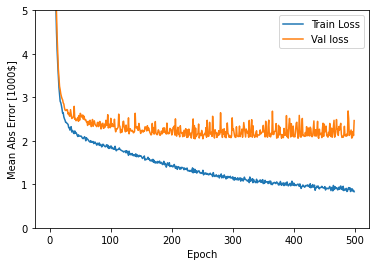

In [20]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mae']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)

This graph shows little improvement in the model after about 200 epochs. Let's update the model.fit method to automatically stop training when the validation score doesn't improve. We'll use a callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://keras.io/callbacks/#earlystopping).

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)



....................................................................................................
......................................

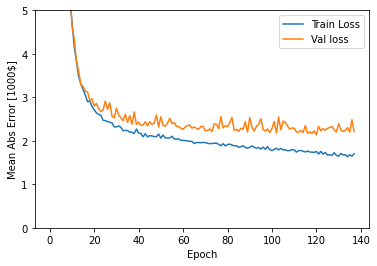

In [21]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

The graph shows the average error is about \$2,500 dollars. Is this good? Well, \$2,500 is not an insignificant amount when some of the labels are only $15,000.

Let's see how did the model performs on the test set:

In [22]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $2737.55


#Predict
Finally, predict some housing prices using data in the testing set:

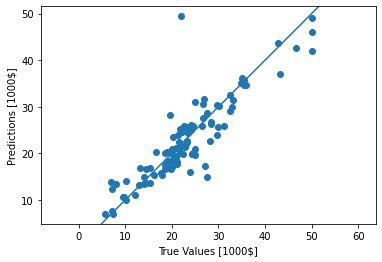

In [23]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1000$]')
plt.ylabel('Predictions [1000$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

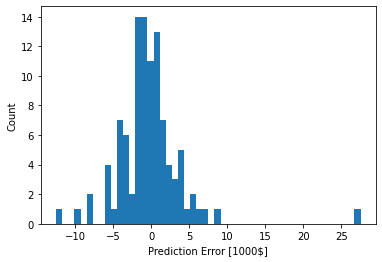

In [24]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [1000$]")
_ = plt.ylabel("Count")

# Conclusion
This notebook introduced a few techniques to handle a regression problem.

*   Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).
*Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
*When input data features have values with different ranges, each feature should be scaled independently.
*If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.
*Early stopping is a useful technique to prevent overfitting.